#### Важное требование ко всей домашке в целом: в jupyter ноутбуке не должно был лишнего кода (т.е. если вы взяли за основу семинар, не забудьте удалить все лишнее)

In [2]:
import tensorflow as tf
import numpy as np
import pandas as pd
from string import punctuation
from sklearn.model_selection import train_test_split
from collections import Counter
import matplotlib.pyplot as plt
from sklearn.decomposition import TruncatedSVD
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.metrics.pairwise import cosine_distances

import pymorphy2
morph = pymorphy2.MorphAnalyzer()

%matplotlib inline

2023-02-10 13:02:16.413302: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


In [3]:
wiki = open('wiki_data.txt').read().split('\n')

# Задание 1 (3 балла)

Обучите word2vec модели с негативным семплированием (cbow и skip-gram) с помощью tensorflow аналогично тому, как это было сделано в семинаре. Вам нужно изменить следующие пункты: 
1) добавьте лемматизацию в предобработку (любым способом)  
2) измените размер окна на 6 для cbow и 12 для skip gram (обратите внимание, что размер окна = #слов слева + #слов справа, в gen_batches в семинаре window используется не так и вам нужно это  изменить!)  

Выберете несколько не похожих по смыслу слов, и протестируйте полученные эмбединги (найдите ближайшие слова и оцените правильность, как в семинаре)

In [36]:
def most_similar(word, embeddings):
    similar = [id2word[i] for i in 
               cosine_distances(embeddings[word2id[word]].reshape(1, -1), embeddings).argsort()[0][:10]]
    return similar

In [15]:
import re
def preprocess(text):
    tokens = re.sub('#+', ' ', text.lower()).split()
    tokens = [token.strip(punctuation) for token in tokens]
    #tokens = [token for token in tokens if token]
    
    lemmas = [morph.parse(word)[0].normal_form for word in tokens]
    return lemmas

In [17]:
vocab = Counter()

for text in wiki:
    vocab.update(preprocess(text))

In [19]:
filtered_vocab = set()

for word in vocab:
    if vocab[word] > 30:
        filtered_vocab.add(word)

In [21]:
word2id = { 'PAD':0}

for word in filtered_vocab:
    word2id[word] = len(word2id)

In [22]:
id2word = {i:word for word, i in word2id.items()}

In [23]:
sentences = []

for text in wiki:
    tokens = preprocess(text)
    if not tokens:
        continue
    ids = [word2id[token] for token in tokens if token in word2id]
    sentences.append(ids)

In [31]:
vocab_size = len(id2word)

#### Skip gram

In [28]:
def gen_batches_sg(sentences, window = 5, batch_size=1000):
    while True:
        X_target = []
        X_context = []
        y = []

        for sent in sentences:
            for i in range(len(sent)-1):
                word = sent[i]
                context = sent[max(0, i-window//2):i] + sent[i+1:i+window//2]
                for context_word in context:
                    X_target.append(word)
                    X_context.append(context_word)
                    y.append(1)
                    
                    X_target.append(word)
                    X_context.append(np.random.randint(vocab_size))
                    y.append(0)
                    
                    if len(X_target) >= batch_size:
                        X_target = np.array(X_target)
                        X_context = np.array(X_context)
                        y = np.array(y)
                        yield ((X_target, X_context), y)
                        X_target = []
                        X_context = []
                        y = []

In [29]:
inputs_target = tf.keras.layers.Input(shape=(1,))
inputs_context = tf.keras.layers.Input(shape=(1,))


embeddings_target = tf.keras.layers.Embedding(input_dim=len(word2id), output_dim=300)(inputs_target, )
embeddings_context = tf.keras.layers.Embedding(input_dim=len(word2id), output_dim=300)(inputs_context, )

target = tf.keras.layers.Flatten()(embeddings_target)
context = tf.keras.layers.Flatten()(embeddings_context)

dot = tf.keras.layers.Dot(1)([target, context])
outputs = tf.keras.layers.Activation(activation='sigmoid')(dot)

model = tf.keras.Model(inputs=[inputs_target, inputs_context], 
                       outputs=outputs)
optimizer = tf.keras.optimizers.Adam(learning_rate=0.001)
model.compile(optimizer=optimizer,
              loss='binary_crossentropy',
              metrics=['accuracy'])

2023-02-10 15:46:20.198134: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


In [32]:
model.fit(gen_batches_sg(sentences[:19000], window=12),
          validation_data=gen_batches_sg(sentences[19000:],  window=12),
          batch_size=1000,
          steps_per_epoch=10000,
          validation_steps=30,
         epochs=2)

Epoch 1/2
10000/10000 [==============================] - 1298s 130ms/step - loss: 0.4483 - accuracy: 0.7988 - val_loss: 0.5107 - val_accuracy: 0.7918
Epoch 2/2
10000/10000 [==============================] - 796s 80ms/step - loss: 0.4289 - accuracy: 0.8142 - val_loss: 0.4493 - val_accuracy: 0.8094


In [49]:
embeddings_sg = model.layers[2].get_weights()[0]

In [50]:
most_similar('работа', embeddings_sg)

['работа',
 'программа',
 'производство',
 'подготовить',
 'разработка',
 'проект',
 'деятельность',
 'реализация',
 'научный',
 'создание']

In [47]:
most_similar('самолёт', embeddings_sg)

['самолёт',
 'танк',
 'истребитель',
 'уничтожить',
 'артиллерийский',
 'авиация',
 'воздушный',
 'десант',
 'сбить',
 'вражеский']

In [48]:
most_similar('париж', embeddings_sg)

['париж',
 'актриса',
 'драматический',
 'италия',
 'мартин',
 'франция',
 'издательство',
 'олег',
 'студент',
 'лос-анджелес']

#### Cbow

In [52]:
# # cbow 
def gen_batches_cbow(sentences, window = 5, batch_size=1000):
    while True:
        X_target = []
        X_context = []
        y = []

        for sent in sentences:
            for i in range(len(sent)-1):
                word = sent[i]
                context = sent[max(0, i-window//2):i] + sent[i+1:i+window//2]

                X_target.append(word)
                X_context.append(context)
                y.append(1)
                
                X_target.append(np.random.randint(vocab_size))
                X_context.append(context)
                y.append(0)

                if len(X_target) == batch_size:
                    X_target = np.array(X_target)
                    X_context = tf.keras.preprocessing.sequence.pad_sequences(X_context, maxlen=window*2)
                    y = np.array(y)
                    yield ((X_target, X_context), y)
                    X_target = []
                    X_context = []
                    y = []

In [53]:
inputs_target = tf.keras.layers.Input(shape=(1,))
inputs_context = tf.keras.layers.Input(shape=(10,))


embeddings_target = tf.keras.layers.Embedding(input_dim=len(word2id), output_dim=300)(inputs_target, )
embeddings_context = tf.keras.layers.Embedding(input_dim=len(word2id), output_dim=300)(inputs_context, )

target = tf.keras.layers.Flatten()(embeddings_target)
context = tf.keras.layers.Lambda(lambda x: tf.keras.backend.sum(x, axis=1))(embeddings_context)
dot = tf.keras.layers.Dot(1)([target, context])

outputs = tf.keras.layers.Activation(activation='sigmoid')(dot)

model = tf.keras.Model(inputs=[inputs_target, inputs_context], 
                       outputs=outputs)


optimizer = tf.keras.optimizers.Adam(learning_rate=0.001)
model.compile(optimizer=optimizer,
              loss='binary_crossentropy',
              metrics=['accuracy'])

In [55]:
model.fit(gen_batches_cbow(sentences[:19000], window=6),
          validation_data=gen_batches_cbow(sentences[19000:],  window=6),
          batch_size=1000,
          steps_per_epoch=5000,
          validation_steps=30,
         epochs=3)

Epoch 1/3
5000/5000 [==============================] - 477s 95ms/step - loss: 0.3594 - accuracy: 0.8456 - val_loss: 0.3081 - val_accuracy: 0.8731
Epoch 2/3
5000/5000 [==============================] - 457s 91ms/step - loss: 0.2722 - accuracy: 0.8882 - val_loss: 0.2642 - val_accuracy: 0.8923
Epoch 3/3
5000/5000 [==============================] - 740s 148ms/step - loss: 0.2247 - accuracy: 0.9084 - val_loss: 0.2741 - val_accuracy: 0.8906


In [56]:
embeddings_cbow = model.layers[2].get_weights()[0]

In [58]:
most_similar('работа', embeddings_cbow)

['работа',
 'который',
 'они',
 'и',
 'он',
 'деятельность',
 'свой',
 'год',
 'в',
 'быть']

In [59]:
most_similar('школа', embeddings_cbow)

['школа',
 'университет',
 'училище',
 'класс',
 'преподаватель',
 'академия',
 'учиться',
 'институт',
 'учитель',
 'курс']

In [60]:
most_similar('кошка', embeddings_cbow)

['кошка',
 'крокодил',
 'клещ',
 'кусочек',
 'аннабет',
 'гроувера',
 'поедать',
 'свинья',
 'паразит',
 'ловить']

In [64]:
most_similar('самолёт', embeddings_cbow)

['самолёт',
 'истребитель',
 'танк',
 'машина',
 'корабль',
 'ракета',
 'вертолёт',
 'автомобиль',
 'двигатель',
 'вооружение']

# Задание 2 (3 балла)

Обучите 1 word2vec и 1 fastext модель в gensim. В каждой из модели нужно задать все параметры, которые мы разбирали на семинаре. Заданные значения должны отличаться от дефолтных и от тех, что мы использовали на семинаре.

In [70]:
import gensim
from gensim.models import Word2Vec

In [66]:
wiki = open('wiki_data.txt').read().split('\n')

In [68]:
def preprocess(text):
    tokens = re.sub('#+', ' ', text.lower()).split()
    tokens = [token.strip(punctuation) for token in tokens]
    tokens = [token for token in tokens if token]
    return tokens

In [69]:
texts = [preprocess(text) for text in wiki]

In [80]:
w2v = gensim.models.Word2Vec(texts, 
                             vector_size=150, 
                             min_count=10, 
                             max_vocab_size=13000,
                             window=6,
                             epochs=10,
                             sg=0,
                             hs=1,
                             negative=15,
                             sample=1e-4,
                             ns_exponent=0.9,
                             cbow_mean=0)

In [81]:
w2v.wv.most_similar('школа')

[('сад', 0.8062271475791931),
 ('школы', 0.7928892970085144),
 ('только', 0.7844210863113403),
 ('по', 0.7843385934829712),
 ('в', 0.7838792204856873),
 ('на', 0.7812486290931702),
 ('селе', 0.7807595133781433),
 ('также', 0.7798526287078857),
 ('уже', 0.779812753200531),
 ('дом', 0.779140293598175)]

In [83]:
w2v.wv.most_similar('музей')

[('музея', 0.7987972497940063),
 ('парк', 0.7972657680511475),
 ('в', 0.7907548546791077),
 ('который', 0.7879287600517273),
 ('истории', 0.7870232462882996),
 ('он', 0.7858070731163025),
 ('и', 0.7857315540313721),
 ('году', 0.7813676595687866),
 ('а', 0.7813126444816589),
 ('с', 0.7796851992607117)]

In [85]:
w2v.wv.most_similar('работа')

[('работы', 0.8291668891906738),
 ('это', 0.8055028319358826),
 ('она', 0.7973302602767944),
 ('но', 0.7936908006668091),
 ('в', 0.7902784943580627),
 ('её', 0.7896360754966736),
 ('и', 0.7877787351608276),
 ('ней', 0.7866337299346924),
 ('что', 0.7859464883804321),
 ('однако', 0.7820146083831787)]

In [87]:
ft = gensim.models.FastText(texts, min_n=2, max_n=8)

In [88]:
ft.wv.most_similar('работа')

[('работника', 0.8976490497589111),
 ('работа»', 0.8807265162467957),
 ('работая', 0.8747559189796448),
 ('работе»', 0.8359116911888123),
 ('работодателя', 0.8291420936584473),
 ('работавшая', 0.8271051645278931),
 ('работниц', 0.8251677751541138),
 ('доработана', 0.8221490979194641),
 ('раба', 0.8192058205604553),
 ('работала', 0.8170024752616882)]

In [89]:
ft.wv.most_similar('кошка')

[('колюшка', 0.9570229649543762),
 ('коха', 0.9442157745361328),
 ('кожа', 0.9310123920440674),
 ('коса', 0.9286544322967529),
 ('колчака', 0.928449273109436),
 ('хэнкока', 0.9264490008354187),
 ('козявка', 0.9249113202095032),
 ('корка', 0.9186483025550842),
 ('ка', 0.9174485206604004),
 ('коба', 0.9149417281150818)]

In [90]:
ft.wv.most_similar('париж')

[('парикмахер', 0.8383645415306091),
 ('паркерсберг', 0.8351565003395081),
 ('паркер', 0.8332021236419678),
 ('парик', 0.8216646909713745),
 ('пенджари', 0.8036128878593445),
 ('пайпер', 0.7813020944595337),
 ('партер', 0.7801513671875),
 ('хейберг', 0.7757096886634827),
 ('гринцер', 0.7734072804450989),
 ('парке»', 0.7709639072418213)]

# Задание 3 (4 балла)

Используя датасет для классификации (labeled.csv) и простую нейронную сеть (последняя модель в семинаре), оцените качество полученных эмбедингов в задании 1 и 2 (4 набора эмбедингов), также проверьте 1 любую из предобученных моделей с rus-vectores (но только не tayga_upos_skipgram_300_2_2019). 
Какая модель показывает наилучший результат?

Убедитесь, что для каждой модели вы корректно воспроизводите пайплайн предобработки (в 1 задании у вас лемматизация, не забудьте ее применить к датасету для классификации; у выбранной предобученной модели может быть своя специфичная предобработка - ее нужно воспроизвести)

In [114]:
def preprocess(text):
    tokens = re.sub('#+', ' ', text.lower()).split()
    tokens = [token.strip(punctuation) for token in tokens]
    #tokens = [token for token in tokens if token]
    
    lemmas = [morph.parse(word)[0].normal_form for word in tokens]
    return lemmas

In [115]:
data = pd.read_csv('labeled.csv')

In [116]:
data['norm_text'] = data.comment.apply(preprocess)

In [117]:
data.head()

,comment,toxic,norm_text
0,"Верблюдов-то за что? Дебилы, бл...\n",1.0,"[верблюд-то, за, что, дебил, бл]"
1,"Хохлы, это отдушина затюканого россиянина, мол...",1.0,"[хохол, это, отдушина, затюканый, россиянин, м..."
2,Собаке - собачья смерть\n,1.0,"[собака, , собачий, смерть]"
3,"Страницу обнови, дебил. Это тоже не оскорблени...",1.0,"[страница, обновить, дебил, это, тоже, не, оск..."
4,"тебя не убедил 6-страничный пдф в том, что Скр...",1.0,"[ты, не, убедить, 6-страничный, пдф, в, тот, ч..."


In [118]:
vocab = Counter()

for text in data['norm_text']:
    vocab.update(text)
    
filtered_vocab = set()

for word in vocab:
    if vocab[word] > 5:
        filtered_vocab.add(word)

len(filtered_vocab)

6309

In [119]:
word2id = { 'PAD':0}

for word in filtered_vocab:
    word2id[word] = len(word2id)
id2word = {i:word for word, i in word2id.items()}

In [120]:
X = []

for tokens in data['norm_text']:
    ids = [word2id[token] for token in tokens if token in word2id]
    X.append(ids)
    
X = tf.keras.preprocessing.sequence.pad_sequences(X, maxlen=100)
y = data.toxic.values

In [121]:
X_train, X_valid, y_train, y_valid = train_test_split(X, y, test_size=0.05)

In [99]:
weights = np.zeros((len(word2id), 100))

for word, i in word2id.items():
    if word == 'PAD':
        continue

    try:
        weights[i] = ft.wv[word]
    
    
    except KeyError:
        continue
        weights[i] = ft.wv['ывлоарывд']


inputs = tf.keras.layers.Input(shape=(100,))


embeddings = tf.keras.layers.Embedding(input_dim=len(word2id), output_dim=100, 
                                       trainable=True,
                                       weights=[weights])(inputs, )
mean = tf.keras.layers.Lambda(lambda x: tf.keras.backend.mean(x,  axis=1))(embeddings)

outputs = tf.keras.layers.Dense(1, activation='sigmoid')(mean)

model = tf.keras.Model(inputs=inputs, outputs=outputs)
optimizer = tf.keras.optimizers.Adam()
model.compile(optimizer=optimizer,
              loss='binary_crossentropy',
              metrics=['accuracy'])

In [100]:
model.fit(X_train, y_train, 
          validation_data=(X_valid, y_valid),
          batch_size=32,
          epochs=30)

Epoch 1/30
428/428 [==============================] - 9s 18ms/step - loss: 0.6161 - accuracy: 0.6637 - val_loss: 0.5677 - val_accuracy: 0.6755
Epoch 2/30
428/428 [==============================] - 4s 10ms/step - loss: 0.5624 - accuracy: 0.6900 - val_loss: 0.5208 - val_accuracy: 0.7254
Epoch 3/30
428/428 [==============================] - 5s 11ms/step - loss: 0.5142 - accuracy: 0.7352 - val_loss: 0.4722 - val_accuracy: 0.7878
Epoch 4/30
428/428 [==============================] - 5s 12ms/step - loss: 0.4670 - accuracy: 0.7858 - val_loss: 0.4328 - val_accuracy: 0.8058
Epoch 5/30
428/428 [==============================] - 5s 13ms/step - loss: 0.4256 - accuracy: 0.8219 - val_loss: 0.4024 - val_accuracy: 0.8183
Epoch 6/30
428/428 [==============================] - 5s 11ms/step - loss: 0.3910 - accuracy: 0.8456 - val_loss: 0.3805 - val_accuracy: 0.8211
Epoch 7/30
428/428 [==============================] - 5s 11ms/step - loss: 0.3628 - accuracy: 0.8624 - val_loss: 0.3616 - val_accuracy: 0.8322

dict_keys(['loss', 'accuracy', 'val_loss', 'val_accuracy'])


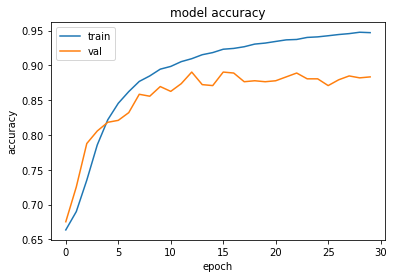

In [101]:
print(model.history.history.keys())
# summarize history for accuracy
plt.plot(model.history.history['accuracy'])
plt.plot(model.history.history['val_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.show()

#### Word2vec

In [130]:
X = []

for tokens in data['norm_text']:
    ids = [word2id[token] for token in tokens if token in word2id]
    X.append(ids)
    
X = tf.keras.preprocessing.sequence.pad_sequences(X, maxlen=150)
y = data.toxic.values

In [131]:
X_train, X_valid, y_train, y_valid = train_test_split(X, y, test_size=0.05)

In [132]:
weights = np.zeros((len(word2id), 150))

for word, i in word2id.items():
    if word == 'PAD':
        continue

    try:
        weights[i] = w2v.wv[word]
    
    except KeyError:
        continue
        weights[i] = w2v.wv['ывлоарывд']
        
inputs = tf.keras.layers.Input(shape=(150,))
embeddings = tf.keras.layers.Embedding(input_dim=len(word2id), output_dim=150, 
                                        trainable=False,
                                        weights=[weights])(inputs, )
mean = tf.keras.layers.Lambda(lambda x: tf.keras.backend.mean(x,  axis=1))(embeddings)

outputs = tf.keras.layers.Dense(1, activation='sigmoid')(mean)

model = tf.keras.Model(inputs=inputs, outputs=outputs)
optimizer = tf.keras.optimizers.Adam()
model.compile(optimizer=optimizer,
                loss='binary_crossentropy',
                metrics=['accuracy'])

In [133]:
model.fit(X_train, y_train, 
          validation_data=(X_valid, y_valid),
          batch_size=32,
          epochs=30)

Epoch 1/30
428/428 [==============================] - 2s 4ms/step - loss: 0.6401 - accuracy: 0.6612 - val_loss: 0.6354 - val_accuracy: 0.6408
Epoch 2/30
428/428 [==============================] - 1s 3ms/step - loss: 0.6180 - accuracy: 0.6664 - val_loss: 0.6352 - val_accuracy: 0.6408
Epoch 3/30
428/428 [==============================] - 2s 4ms/step - loss: 0.6173 - accuracy: 0.6664 - val_loss: 0.6350 - val_accuracy: 0.6408
Epoch 4/30
428/428 [==============================] - 1s 3ms/step - loss: 0.6171 - accuracy: 0.6664 - val_loss: 0.6350 - val_accuracy: 0.6408
Epoch 5/30
428/428 [==============================] - 1s 3ms/step - loss: 0.6169 - accuracy: 0.6664 - val_loss: 0.6345 - val_accuracy: 0.6408
Epoch 6/30
428/428 [==============================] - 1s 3ms/step - loss: 0.6168 - accuracy: 0.6664 - val_loss: 0.6347 - val_accuracy: 0.6408
Epoch 7/30
428/428 [==============================] - 1s 3ms/step - loss: 0.6166 - accuracy: 0.6664 - val_loss: 0.6343 - val_accuracy: 0.6408
Epoch 

dict_keys(['loss', 'accuracy', 'val_loss', 'val_accuracy'])


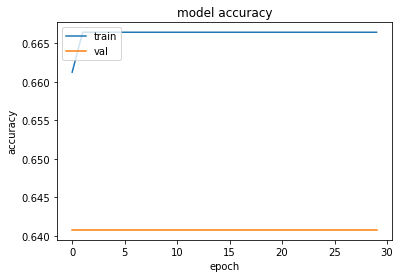

In [137]:
print(model.history.history.keys())
# summarize history for accuracy
plt.plot(model.history.history['accuracy'])
plt.plot(model.history.history['val_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.show()

#### Skip-gram

In [140]:
X = tf.keras.preprocessing.sequence.pad_sequences(X, maxlen=300)
y = data.toxic.values

X_train, X_valid, y_train, y_valid = train_test_split(X, y, test_size=0.1)

In [149]:
weights = np.zeros((len(word2id), 300))
weights_sg = embeddings_sg

for i in id2word.keys(): 
    if i == 0:
        continue
    try:
        weights[i] = embeddings_sg[i]
      
      
    except KeyError:
        continue
        weights[i] = weights_sg[999999999999999] 

inputs = tf.keras.layers.Input(shape=(300,))

embeddings = tf.keras.layers.Embedding(input_dim=len(word2id), output_dim=300, 
                                        trainable=False,
                                        weights=[weights])(inputs, )
mean = tf.keras.layers.Lambda(lambda x: tf.keras.backend.mean(x,  axis=1))(embeddings)

outputs = tf.keras.layers.Dense(1, activation='sigmoid')(mean)

model_sg = tf.keras.Model(inputs=inputs, outputs=outputs)
optimizer = tf.keras.optimizers.Adam()
model_sg.compile(optimizer=optimizer,
                loss='binary_crossentropy',
                metrics=['accuracy'])

In [151]:
model_sg.fit(X_train, y_train, 
          validation_data=(X_valid, y_valid),
          batch_size=32,
          epochs=30)

Epoch 1/30
406/406 [==============================] - 5s 10ms/step - loss: 0.6584 - accuracy: 0.6639 - val_loss: 0.6322 - val_accuracy: 0.6748
Epoch 2/30
406/406 [==============================] - 3s 8ms/step - loss: 0.6308 - accuracy: 0.6641 - val_loss: 0.6201 - val_accuracy: 0.6748
Epoch 3/30
406/406 [==============================] - 4s 11ms/step - loss: 0.6260 - accuracy: 0.6641 - val_loss: 0.6174 - val_accuracy: 0.6748
Epoch 4/30
406/406 [==============================] - 7s 17ms/step - loss: 0.6250 - accuracy: 0.6641 - val_loss: 0.6168 - val_accuracy: 0.6748
Epoch 5/30
406/406 [==============================] - 5s 11ms/step - loss: 0.6246 - accuracy: 0.6641 - val_loss: 0.6162 - val_accuracy: 0.6748
Epoch 6/30
406/406 [==============================] - 4s 9ms/step - loss: 0.6242 - accuracy: 0.6641 - val_loss: 0.6159 - val_accuracy: 0.6748
Epoch 7/30
406/406 [==============================] - 3s 8ms/step - loss: 0.6240 - accuracy: 0.6641 - val_loss: 0.6157 - val_accuracy: 0.6748
Ep

dict_keys(['loss', 'accuracy', 'val_loss', 'val_accuracy'])


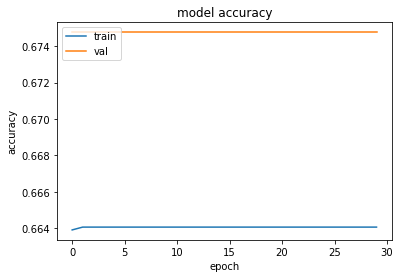

In [152]:
print(model_sg.history.history.keys())
# summarize history for accuracy
plt.plot(model_sg.history.history['accuracy'])
plt.plot(model_sg.history.history['val_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.show()

#### Cbow

In [154]:
X = []

for tokens in data['norm_text']:
    ids = [word2id[token] for token in tokens if token in word2id]
    X.append(ids)
    
X = tf.keras.preprocessing.sequence.pad_sequences(X, maxlen=300)
y = data.toxic.values

In [155]:
X_train, X_valid, y_train, y_valid = train_test_split(X, y, test_size=0.05)

In [158]:
weights = np.zeros((len(word2id), 300))
weights_cbow = embeddings_cbow

for i in id2word.keys(): 
    if i == 0:
        continue
    try:
        weights[i] = embeddings_cbow[i]
      
      
    except KeyError:
        continue
        weights[i] = weights_cbow[999999999999999] 

inputs = tf.keras.layers.Input(shape=(300,))

embeddings = tf.keras.layers.Embedding(input_dim=len(word2id), output_dim=300, 
                                        trainable=False,
                                        weights=[weights])(inputs, )
mean = tf.keras.layers.Lambda(lambda x: tf.keras.backend.mean(x,  axis=1))(embeddings)

outputs = tf.keras.layers.Dense(1, activation='sigmoid')(mean)

model_cbow = tf.keras.Model(inputs=inputs, outputs=outputs)
optimizer = tf.keras.optimizers.Adam()
model_cbow.compile(optimizer=optimizer,
                loss='binary_crossentropy',
                metrics=['accuracy'])

In [159]:
model_cbow.fit(X_train, y_train, 
          validation_data=(X_valid, y_valid),
          batch_size=32,
          epochs=30)

Epoch 1/30
428/428 [==============================] - 4s 8ms/step - loss: 0.6447 - accuracy: 0.6666 - val_loss: 0.6382 - val_accuracy: 0.6394
Epoch 2/30
428/428 [==============================] - 3s 8ms/step - loss: 0.6280 - accuracy: 0.6665 - val_loss: 0.6387 - val_accuracy: 0.6394
Epoch 3/30
428/428 [==============================] - 3s 8ms/step - loss: 0.6271 - accuracy: 0.6665 - val_loss: 0.6388 - val_accuracy: 0.6394
Epoch 4/30
428/428 [==============================] - 3s 7ms/step - loss: 0.6265 - accuracy: 0.6665 - val_loss: 0.6393 - val_accuracy: 0.6394
Epoch 5/30
428/428 [==============================] - 3s 8ms/step - loss: 0.6262 - accuracy: 0.6665 - val_loss: 0.6388 - val_accuracy: 0.6394
Epoch 6/30
428/428 [==============================] - 3s 8ms/step - loss: 0.6258 - accuracy: 0.6665 - val_loss: 0.6387 - val_accuracy: 0.6394
Epoch 7/30
428/428 [==============================] - 3s 7ms/step - loss: 0.6255 - accuracy: 0.6665 - val_loss: 0.6384 - val_accuracy: 0.6394
Epoch 

dict_keys(['loss', 'accuracy', 'val_loss', 'val_accuracy'])


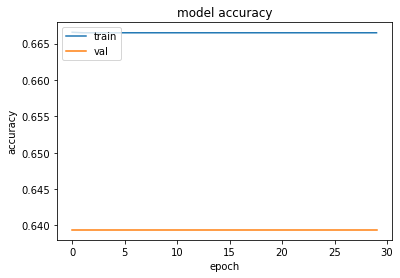

In [160]:
print(model_cbow.history.history.keys())
# summarize history for accuracy
plt.plot(model_cbow.history.history['accuracy'])
plt.plot(model_cbow.history.history['val_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.show()

#### RusVectores

In [171]:
#ruscorpora_upos_cbow_300_20_2019
model_rv = gensim.models.KeyedVectors.load_word2vec_format('model.bin', binary=True)

In [173]:
X = tf.keras.preprocessing.sequence.pad_sequences(X, maxlen=300)
y = data.toxic.values

In [175]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.1)

In [176]:
weights = np.zeros((len(word2id), 300))

for word, i in word2id.items():
    if word == 'PAD':
        continue

    try:
        weights[i] = model_rv[word]
    
    except KeyError:
        continue
        weights[i] = model_rv['ывйдаоыйвдлпо']
        
inputs = tf.keras.layers.Input(shape=(300,))
embeddings = tf.keras.layers.Embedding(input_dim=len(word2id), output_dim=300, 
                                        trainable=False,
                                        weights=[weights])(inputs, )
mean = tf.keras.layers.Lambda(lambda x: tf.keras.backend.mean(x,  axis=1))(embeddings)

outputs = tf.keras.layers.Dense(1, activation='sigmoid')(mean)

model_rv_class = tf.keras.Model(inputs=inputs, outputs=outputs)
optimizer = tf.keras.optimizers.Adam()
model_rv_class.compile(optimizer=optimizer,
                loss='binary_crossentropy',
                metrics=['accuracy'])

In [180]:
model_rv_class.fit(X_train, y_train, 
          validation_data=(X_test, y_test),
          batch_size=32,
          epochs=30)

Epoch 1/30
406/406 [==============================] - 3s 8ms/step - loss: 0.6387 - accuracy: 0.6635 - val_loss: 0.6276 - val_accuracy: 0.6796
Epoch 2/30
406/406 [==============================] - 3s 8ms/step - loss: 0.6387 - accuracy: 0.6635 - val_loss: 0.6277 - val_accuracy: 0.6796
Epoch 3/30
406/406 [==============================] - 4s 9ms/step - loss: 0.6387 - accuracy: 0.6635 - val_loss: 0.6278 - val_accuracy: 0.6796
Epoch 4/30
406/406 [==============================] - 4s 9ms/step - loss: 0.6387 - accuracy: 0.6635 - val_loss: 0.6278 - val_accuracy: 0.6796
Epoch 5/30
406/406 [==============================] - 3s 8ms/step - loss: 0.6387 - accuracy: 0.6635 - val_loss: 0.6278 - val_accuracy: 0.6796
Epoch 6/30
406/406 [==============================] - 3s 7ms/step - loss: 0.6387 - accuracy: 0.6635 - val_loss: 0.6278 - val_accuracy: 0.6796
Epoch 7/30
406/406 [==============================] - 3s 8ms/step - loss: 0.6387 - accuracy: 0.6635 - val_loss: 0.6277 - val_accuracy: 0.6796
Epoch 

dict_keys(['loss', 'accuracy', 'val_loss', 'val_accuracy'])


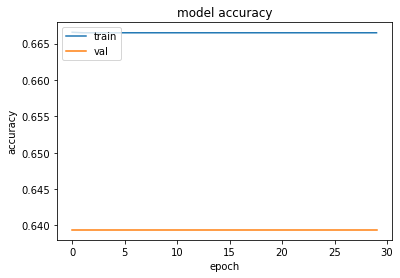

In [178]:
print(model_rv_class.history.history.keys())
# summarize history for accuracy
plt.plot(model_cbow.history.history['accuracy'])
plt.plot(model_cbow.history.history['val_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.show()